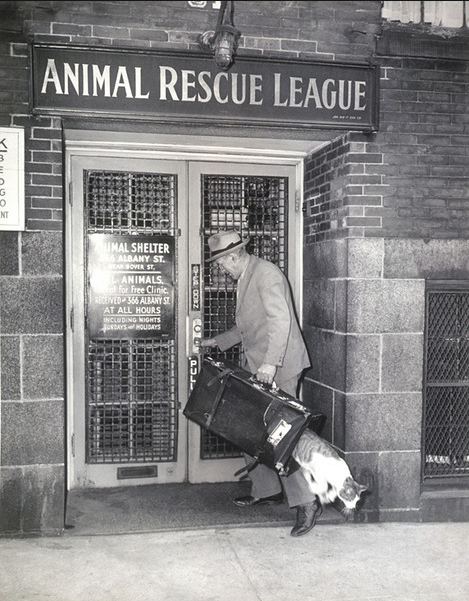

# Overview

Story of tracking down a "memory leak" in the JWST pipeline

# Resources

- Blog: [Things you need to know about garbage collection in Python](https://rushter.com/blog/python-garbage-collector/)
- The collector of garbage: [`gc`](https://docs.python.org/3/library/gc.html)
- [`weakref`](https://docs.python.org/3/library/weakref.html)
- [`memory_profiler`](https://github.com/pythonprofilers/memory_profiler)
- [`objgraph`](https://mg.pov.lt/objgraph/)
- [`pympler`](https://pythonhosted.org/Pympler/)


# What Was Wrong

The original email.

Bottom line, SDP had two calwebb_spec2 tasks that had run 23.5 hours using a combined 146Gb memory before being mercifully terminated:

```
 Also note:   the leftover jobs from Mary (actually a GOOD test to see what would happen to them) CLAIM to be taking 73Gb (!!!) of memory

-- Schedd: iljwdmsbcsched.stsci.edu : <10.132.12.101:9618?... @ 09/08/17 14:16:03
ID        OWNER            SUBMITTED     RUN_TIME ST PRI SIZE    CMD
636992.0   mary            9/7  14:44   0+23:31:58 R  0       0.3 condor_dagman -f -l . -Debug 3 –Lockfile level_2b_jw9313
636993.0   mary            9/7  14:44   0+23:31:57 R  130 73243.0 calibration_wrapper.csh jw93135-o012_20170905t081006_spe
636994.0   mary            9/7  14:44   0+23:31:37 R  0       0.3 condor_dagman -f -l . -Debug 3 -Lockfile level_2b_jw9313
636995.0   mary            9/7  14:44   0+23:31:32 R  130 73243.0 calibration_wrapper.csh jw93135-o021_20170905t081006_spe

4 jobs; 0 completed, 0 removed, 0 idle, 4 running, 0 held, 0 suspended
```

### Why now?

Before Level2 associations, `calwebb_spec2` was run only on single exposures. With Level2 associations, `calwebb_spec2` looped over all the exposures in the association.

# Show Me The Memory: memory_profiler

[github repo](https://github.com/pythonprofilers/memory_profiler)

## Test script

```
#!/usr/bin/env python

import gc
from multiprocessing import Pool

try:
    from memory_profiler import profile
except Exception:
    profile = lambda func: func

from jwst.associations import load_asn
from jwst.associations.lib.update_path import update_path
from jwst.pipeline import Spec2Pipeline


def spec2run(fname):
    Spec2Pipeline.call(
        fname,
        config_file='cfgs/calwebb_spec2.cfg',
        output_dir='level2b_test_noloop'
    )


@profile
def main_loop():
    # Get association and update path to exposures
    with open('member_3_spec2_asn.json') as fp:
        lvl2_asn = load_asn(fp)
    update_path(lvl2_asn, 'level2a_preheaderfix')

    # Process
    to_process = []
    for product in lvl2_asn['products']:
        for member in product['members']:
            if member['exptype'].lower() == 'science':
                to_process.append(member['expname'])

    spec2run(to_process.pop())
    gc.collect()
    spec2run(to_process.pop())
    gc.collect()
    spec2run(to_process.pop())
    gc.collect()


# ####
# Main
# ####
if __name__ == '__main__':
    main_loop()

```

## The result

```
Filename: ./calibrate_nocube_noloop.py

Line #    Mem usage    Increment   Line Contents
================================================
    20    110.8 MiB      0.0 MiB   @profile
    21                             def main_loop():
    22                                 # Get association and update path to exposures
    23    110.8 MiB      0.0 MiB       with open('member_3_spec2_asn.json') as fp:
    24    111.1 MiB      0.3 MiB           lvl2_asn = load_asn(fp)
    25    111.1 MiB      0.0 MiB       update_path(lvl2_asn, 'level2a')
    26                             
    27                                 # Process
    28    111.1 MiB      0.0 MiB       to_process = []
    29    111.1 MiB      0.0 MiB       for product in lvl2_asn['products']:
    30    111.1 MiB      0.0 MiB           for member in product['members']:
    31    111.1 MiB      0.0 MiB               if member['exptype'].lower() == 'science':
    32    111.1 MiB      0.0 MiB                   to_process.append(member['expname'])
    33                             
    34   1792.2 MiB   1681.1 MiB       spec2run(to_process.pop())
    35   1792.2 MiB      0.0 MiB       gc.collect()
    36   3313.2 MiB   1521.0 MiB       spec2run(to_process.pop())
    37   3313.0 MiB     -0.2 MiB       gc.collect()
    38   4900.1 MiB   1587.1 MiB       spec2run(to_process.pop())
    39   4899.8 MiB     -0.2 MiB       gc.collect()
```

### Graphically
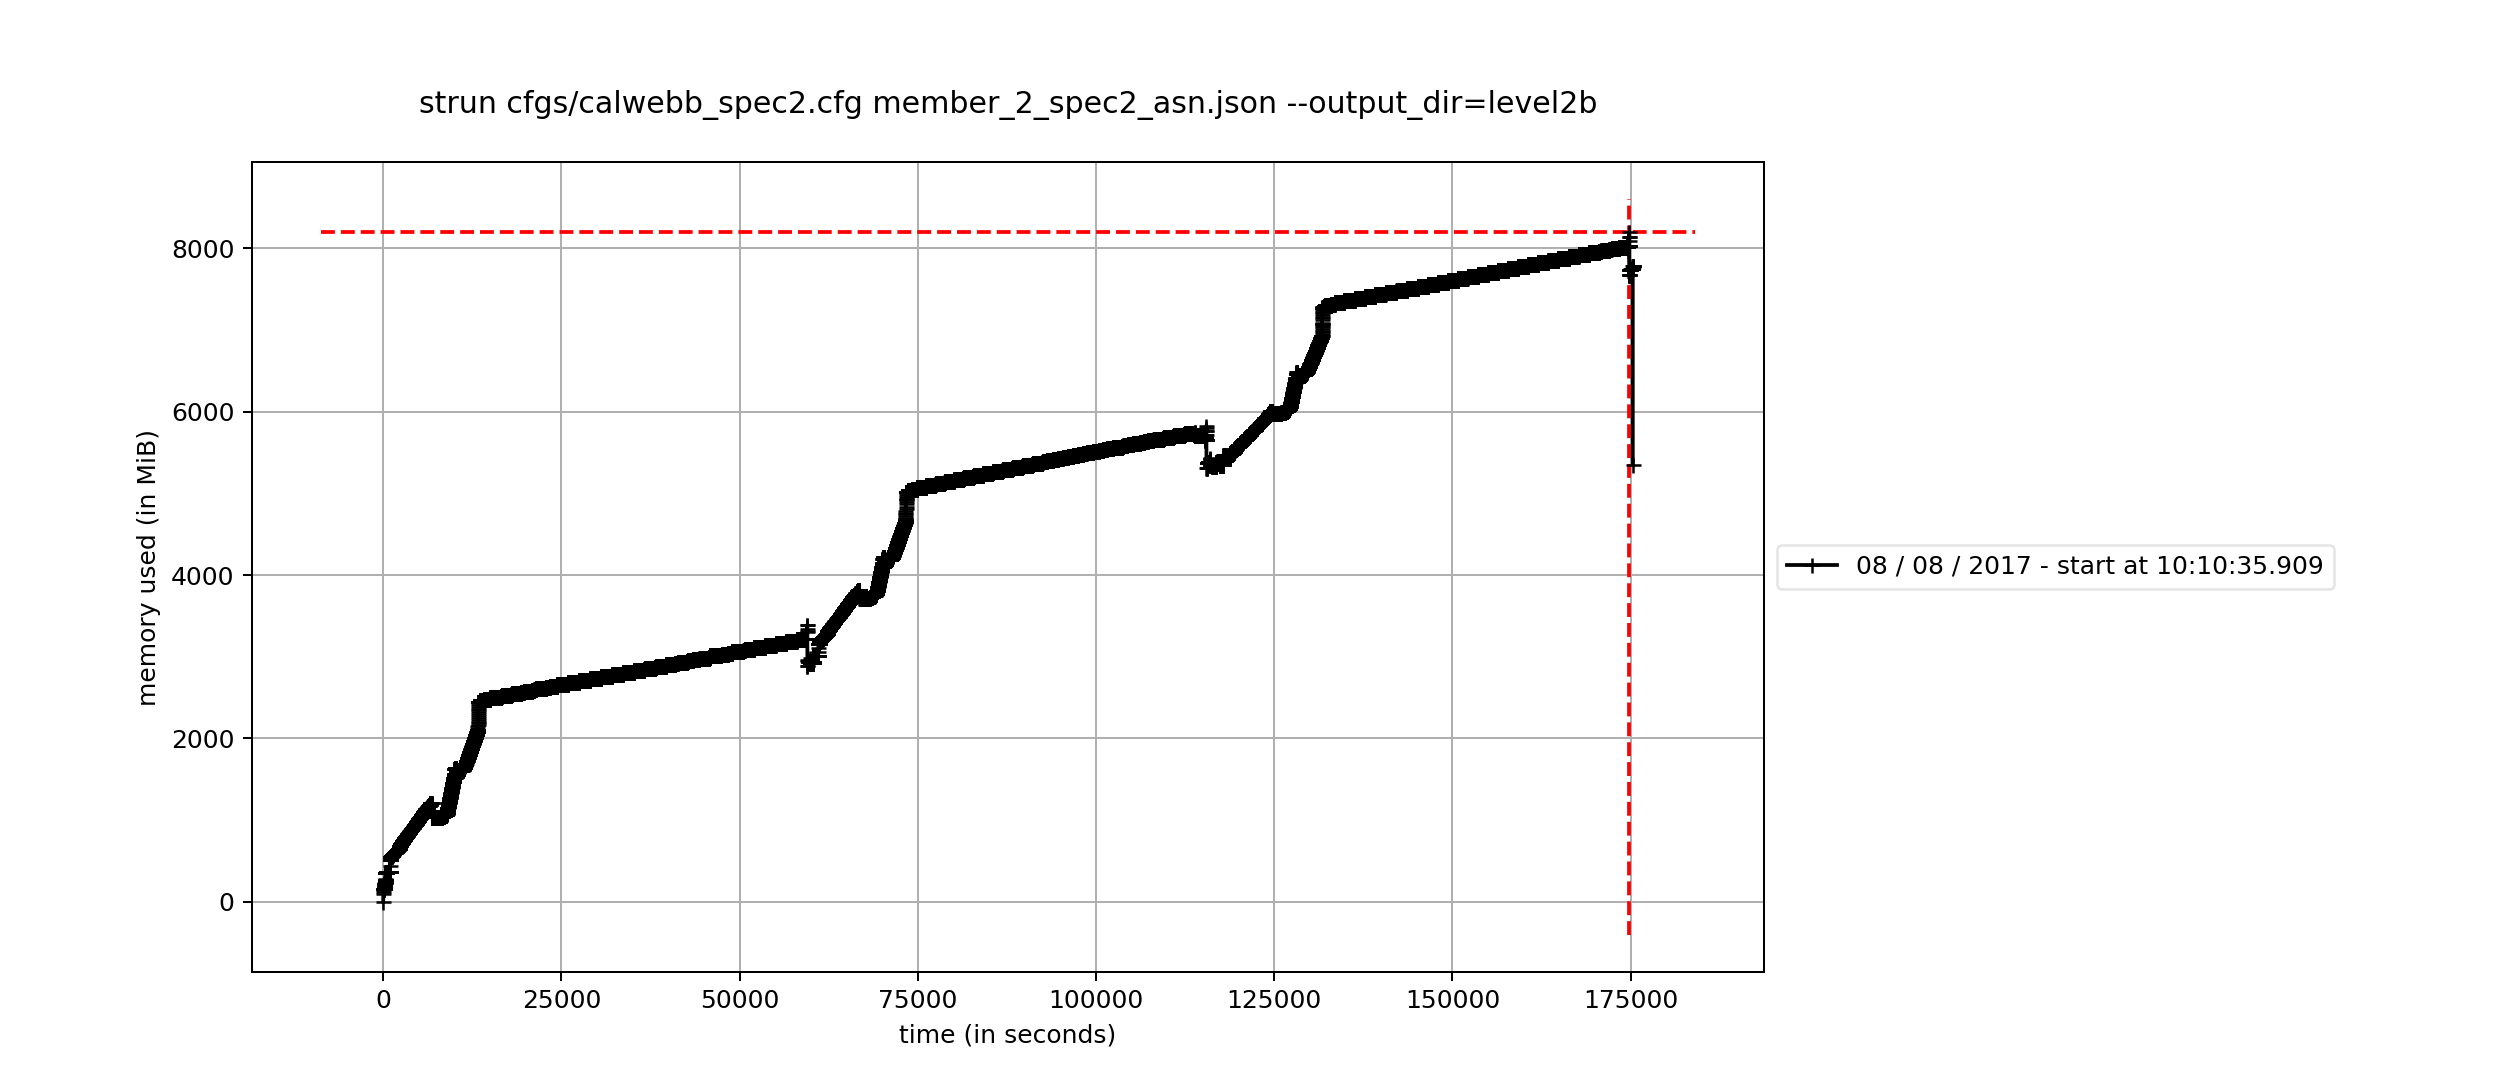

## Quick fixes (ya, no)

- Running separate instantiations of `Spec2Pipeline`: Nope, as seen above
- [`gc.collect`](https://docs.python.org/3/library/gc.html): Nope, as seen above
- [`weakref`](https://docs.python.org/3/library/weakref.html): Nope, result is free!

## Do all the pipelines do this? Nope...

### Sloper
```
Filename: ./calibrate-sloper.py

Line #    Mem usage    Increment   Line Contents
================================================
    21    110.8 MiB      0.0 MiB   @profile
    22                             def main_loop():
    23    110.8 MiB      0.0 MiB       to_process = glob('level1b/*.fits')
    24    845.4 MiB    734.5 MiB       sloperrun(to_process.pop())
    25    466.7 MiB   -378.7 MiB       gc.collect()
    26    805.5 MiB    338.8 MiB       sloperrun(to_process.pop())
    27    177.5 MiB   -628.0 MiB       gc.collect()
    28    807.1 MiB    629.6 MiB       sloperrun(to_process.pop())
    29    495.7 MiB   -311.4 MiB       gc.collect()

```

## A bit more detail: Spec2Pipeline

```
Filename: /home/eisenham/cs-user-eisenham/anaconda3/envs/profiling/lib/python3.5/site-packages/jwst-0.7.7.dev1259-py3.5-linux-x86_64.egg/jwst/pipeline/calwebb_spec2.py

Line #    Mem usage    Increment   Line Contents
================================================
    93   3313.0 MiB      0.0 MiB       @profile
    94                                 def process_exposure_product(
    95                                         self,
    96                                         exp_product,
    97                                         pool_name=' ',
    98                                         asn_file=' '
    99                                 ):
   100                                     """Process an exposure found in the association product
   101                             
   102                                     Parameters
   103                                     ---------
   104                                     exp_product: dict
   105                                         A Level2b association product.
   106                                     """
   107                             
   108                                     # Find all the member types in the product
   109   3313.0 MiB      0.0 MiB           members_by_type = defaultdict(list)
   110   3313.0 MiB      0.0 MiB           for member in exp_product['members']:
   111   3313.0 MiB      0.0 MiB               members_by_type[member['exptype'].lower()].append(member['expname'])
   112                             
   113                                     # Get the science member. Technically there should only be
   114                                     # one. We'll just get the first one found.
   115   3313.0 MiB      0.0 MiB           science = members_by_type['science']
   116   3313.0 MiB      0.0 MiB           if len(science) != 1:
   117                                         self.log.warn(
   118                                             'Wrong number of science exposures found in {}'.format(
   119                                                 exp_product['name']
   120                                             )
   121                                         )
   122                                         self.log.warn('    Using only first one.')
   123   3313.0 MiB      0.0 MiB           science = science[0]
   124                             
   125   3313.0 MiB      0.0 MiB           self.log.info('Working on input %s ...', science)
   126   3313.0 MiB      0.0 MiB           if isinstance(science, datamodels.DataModel):
   127                                         input = science
   128                                     else:
   129   3329.0 MiB     16.0 MiB               input = datamodels.open(science)
   130   3329.0 MiB      0.0 MiB           exp_type = input.meta.exposure.type
   131                             
   132                                     # Apply WCS info
   133   3413.9 MiB     84.9 MiB           input = self.assign_wcs(input)
   134                             
   135                                     # Do background processing, if necessary
   136   3413.9 MiB      0.0 MiB           if len(members_by_type['background']) > 0:
   137                             
   138                                         # Setup for saving
   139                                         self.bkg_subtract.suffix = 'bsub'
   140                                         if isinstance(input, datamodels.CubeModel):
   141                                             self.bkg_subtract.suffix = 'bsubints'
   142                             
   143                                         # Backwards compatibility
   144                                         if self.save_bsub:
   145                                             self.bkg_subtract.save_results = True
   146                             
   147                                         # Call the background subtraction step
   148                                         input = self.bkg_subtract(input, members_by_type['background'])
   149                             
   150                                     # If assign_wcs was skipped, abort the rest of processing,
   151                                     # because so many downstream steps depend on the WCS
   152   3413.9 MiB      0.0 MiB           if input.meta.cal_step.assign_wcs == 'SKIPPED':
   153                                         self.log.error('Assign_wcs processing was skipped')
   154                                         self.log.error('Aborting remaining processing for this exposure')
   155                                         self.log.error('No output product will be created')
   156                                         return input
   157                             
   158                                     # Apply NIRSpec MSA imprint subtraction
   159                                     # Technically there should be just one.
   160                                     # We'll just get the first one found
   161   3413.9 MiB      0.0 MiB           imprint = members_by_type['imprint']
   162   3413.9 MiB      0.0 MiB           if exp_type in ['NRS_MSASPEC', 'NRS_IFU'] and \
   163   3413.9 MiB      0.0 MiB              len(imprint) > 0:
   164                                         if len(imprint) > 1:
   165                                             self.log.warn('Wrong number of imprint members')
   166                                         imprint = imprint[0]
   167                                         input = self.imprint_subtract(input, imprint)
   168                             
   169                                     # Apply NIRSpec MSA bad shutter flagging
   170   3413.9 MiB      0.0 MiB           if exp_type in ['NRS_MSASPEC', 'NRS_IFU']:
   171   3750.2 MiB    336.3 MiB               input = self.msa_flagging(input)
   172                             
   173                                     # Extract 2D sub-windows for NIRSpec slit and MSA
   174   3750.2 MiB      0.0 MiB           if exp_type in ['NRS_FIXEDSLIT', 'NRS_BRIGHTOBJ', 'NRS_MSASPEC']:
   175                                         input = self.extract_2d(input)
   176                             
   177                                     # Apply flat-field correction
   178   4538.8 MiB    788.6 MiB           input = self.flat_field(input)
   179                             
   180                                     # Apply the source type decision step
   181   4448.9 MiB    -89.8 MiB           input = self.srctype(input)
   182                             
   183                                     # Apply the straylight correction for MIRI MRS
   184   4448.9 MiB      0.0 MiB           if exp_type == 'MIR_MRS':
   185                                         input = self.straylight(input)
   186                             
   187                                     # Apply the fringe correction for MIRI MRS
   188   4448.9 MiB      0.0 MiB           if exp_type == 'MIR_MRS':
   189                                         input = self.fringe(input)
   190                             
   191                                     # Apply pathloss correction to NIRSpec exposures
   192   4448.9 MiB      0.0 MiB           if exp_type in ['NRS_FIXEDSLIT', 'NRS_BRIGHTOBJ', 'NRS_MSASPEC',
   193   4448.9 MiB      0.0 MiB                           'NRS_IFU']:
   194   4448.9 MiB      0.0 MiB               input = self.pathloss(input)
   195                             
   196                                     # Apply flux calibration
   197   4930.7 MiB    481.8 MiB           input = self.photom(input)
   198                             
   199                                     # Record ASN pool and table names in output
   200   4930.7 MiB      0.0 MiB           input.meta.asn.pool_name = pool_name
   201   4930.7 MiB      0.0 MiB           input.meta.asn.table_name = asn_file
   202                             
   203                                     # Save the basic calibrated product
   204   4930.7 MiB      0.0 MiB           self.suffix = 'cal'
   205   4930.7 MiB      0.0 MiB           if isinstance(input, datamodels.CubeModel):
   206                                         self.suffix = 'calints'
   207   4936.7 MiB      6.0 MiB           self.save_model(input, self.suffix)
   208                             
   209                                     # Produce a resampled product, either via resample_spec for
   210                                     # "regular" spectra or cube_build for IFU data. No resampled
   211                                     # product is produced for time-series modes.
   212   4936.7 MiB      0.0 MiB           if input.meta.exposure.type in [
   213                                             'NRS_FIXEDSLIT', 'NRS_BRIGHTOBJ',
   214   4936.7 MiB      0.0 MiB                   'NRS_MSASPEC', 'NIS_WFSS', 'NRC_GRISM'
   215                                     ]:
   216                             
   217                                         # Call the resample_spec step
   218                                         self.resample_spec.suffix = 's2d'
   219                                         resamp = self.resample_spec(input)
   220                             
   221                                         # Pass the resampled data to 1D extraction
   222                                         x1d_input = resamp.copy()
   223                                         resamp.close()
   224                             
   225   4936.7 MiB      0.0 MiB           elif exp_type in ['MIR_MRS', 'NRS_IFU']:
   226                             
   227                                         # Call the cube_build step for IFU data
   228   4936.7 MiB      0.0 MiB               self.cube_build.suffix = 's3d'
   229   4931.9 MiB     -4.8 MiB               cube = self.cube_build(input)
   230                             
   231                                         # Pass the cube along for input to 1D extraction
   232   4947.9 MiB     16.0 MiB               x1d_input = cube.copy()
   233   4947.9 MiB      0.0 MiB               cube.close()
   234                             
   235                                     else:
   236                                         # Pass the unresampled cal product to 1D extraction
   237                                         x1d_input = input
   238                             
   239                                     # Extract a 1D spectrum from the 2D/3D data
   240   4947.9 MiB      0.0 MiB           self.extract_1d.suffix = 'x1d'
   241   4947.9 MiB      0.0 MiB           if isinstance(input, datamodels.CubeModel):
   242                                         self.extract_1d.suffix = 'x1dints'
   243   4947.9 MiB      0.0 MiB           x1d_output = self.extract_1d(x1d_input)
   244                             
   245   4947.9 MiB      0.0 MiB           x1d_input.close()
   246   4947.9 MiB      0.0 MiB           input.close()
   247   4947.9 MiB      0.0 MiB           x1d_output.close()
   248                             
   249                                     # That's all folks
   250   4947.9 MiB      0.0 MiB           self.log.info(
   251   4947.9 MiB      0.0 MiB               'Finished processing product {}'.format(exp_product['name'])
   252                                     )
```

## assign_wcs

WHAAAAAAATTTT!!!!!!

```
Filename: ./calibrate_assign_wcs.py

Line #    Mem usage    Increment   Line Contents
================================================
    20    110.8 MiB      0.0 MiB   @profile
    21                             def main_loop():
    22                                 # Get association and update path to exposures
    23    110.8 MiB      0.0 MiB       with open('member_3_spec2_asn.json') as fp:
    24    111.1 MiB      0.3 MiB           lvl2_asn = load_asn(fp)
    25    111.1 MiB      0.0 MiB       update_path(lvl2_asn, 'level2a')
    26                             
    27                                 # Process
    28    111.1 MiB      0.0 MiB       to_process = []
    29    111.1 MiB      0.0 MiB       for product in lvl2_asn['products']:
    30    111.1 MiB     -0.0 MiB           for member in product['members']:
    31    111.1 MiB      0.0 MiB               if member['exptype'].lower() == 'science':
    32    111.1 MiB      0.0 MiB                   to_process.append(member['expname'])
    33                             
    34    309.5 MiB    198.4 MiB       spec2run(to_process.pop())
    35    309.2 MiB     -0.2 MiB       gc.collect()
    36    429.4 MiB    120.1 MiB       spec2run(to_process.pop())
    37    429.1 MiB     -0.2 MiB       gc.collect()
    38    539.8 MiB    110.7 MiB       spec2run(to_process.pop())
    39    539.6 MiB     -0.2 MiB       gc.collect()
```

# Who?

Enter [pympler](https://pythonhosted.org/Pympler/) and [objgraph](https://mg.pov.lt/objgraph/)

In [8]:
# Demo code used to produce the graphs below
# Note: this will most likely not demo the leak in this demonstration.
#       astropy.modeling was fixed for the issue.
import objgraph
import random

from jwst.assign_wcs.nirspec import ifu
from jwst.datamodels import open as dm_open

input_model = dm_open('/grp/jwst/ssb/eisenhamer/jwst_test_data/nirspec/test_datasets/ifu/sdp-20170725/level2a_preheaderfix/jw93135011001_02101_00001_nrs1_rate.fits')

In [3]:
reference_files = {
    'distortion': None,
    'filteroffset': None,
    'specwcs': None,
    'regions': None,
    'wavelengthrange': '/Users/eisenham/Documents/ssbdev/testdata/crds-cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0004.asdf',
    'v2v3': None,
    'camera': '/Users/eisenham/Documents/ssbdev/testdata/crds-cache/references/jwst/nirspec/jwst_nirspec_camera_0004.asdf',
    'collimator': '/Users/eisenham/Documents/ssbdev/testdata/crds-cache/references/jwst/nirspec/jwst_nirspec_collimator_0004.asdf',
    'disperser': '/Users/eisenham/Documents/ssbdev/testdata/crds-cache/references/jwst/nirspec/jwst_nirspec_disperser_0031.asdf',
    'fore': '/Users/eisenham/Documents/ssbdev/testdata/crds-cache/references/jwst/nirspec/jwst_nirspec_fore_0027.asdf',
    'fpa': '/Users/eisenham/Documents/ssbdev/testdata/crds-cache/references/jwst/nirspec/jwst_nirspec_fpa_0005.asdf',
    'msa': '/Users/eisenham/Documents/ssbdev/testdata/crds-cache/references/jwst/nirspec/jwst_nirspec_msa_0005.asdf',
    'ote': '/Users/eisenham/Documents/ssbdev/testdata/crds-cache/references/jwst/nirspec/jwst_nirspec_ote_0004.asdf',
    'ifupost': '/Users/eisenham/Documents/ssbdev/testdata/crds-cache/references/jwst/nirspec/jwst_nirspec_ifupost_0003.asdf',
    'ifufore': '/Users/eisenham/Documents/ssbdev/testdata/crds-cache/references/jwst/nirspec/jwst_nirspec_ifufore_0003.asdf',
    'ifuslicer': '/Users/eisenham/Documents/ssbdev/testdata/crds-cache/references/jwst/nirspec/jwst_nirspec_ifuslicer_0003.asdf'
}

In [4]:
# Clear out the growth charts
objgraph.show_growth()
objgraph.show_growth()
objgraph.show_growth()

list          23482     +3415
PythonNode     4326     +2399
Operator       4397     +2328
Name           3331     +1793
Newline        1292      +691
Keyword        1121      +539
ExprStmt        352      +220
String          307      +191
Param           355      +142
Number          174       +90
cell         2663       +10
function    30215        +5
dict        20048        +3
list     23484        +2
frame       56        +2
dict     20049        +1


In [5]:
# Run the test

ifu(input_model, reference_files)

2017-10-20 10:16:05,892 - stpipe - INFO - gwa_ytilt is 0.1393888
2017-10-20 10:16:05,893 - stpipe - INFO - gwa_xtilt is 0.356661946
2017-10-20 10:16:05,896 - stpipe - INFO - theta_y correction: -0.0033510991648278655
2017-10-20 10:16:05,912 - stpipe - INFO - theta_x correction: 0.0


Filename: /Users/eisenham/anaconda3/envs/profiling/lib/python3.6/site-packages/jwst-0.7.8rc2.dev108-py3.6-macosx-10.7-x86_64.egg/jwst/assign_wcs/nirspec.py

Line #    Mem usage    Increment   Line Contents
   126    142.9 MiB      0.0 MiB   @profile
   127                             def ifu(input_model, reference_files):
   128                                 """
   129                                 IFU pipeline
   130                                 """
   131    142.9 MiB      0.0 MiB       detector = input_model.meta.instrument.detector
   132    142.9 MiB      0.0 MiB       grating = input_model.meta.instrument.grating
   133    142.9 MiB      0.0 MiB       filter = input_model.meta.instrument.filter
   134    142.9 MiB      0.0 MiB       if detector == "NRS2" and grating.endswith('M'):
   135                                     log.critical("No IFU slices fall on detector {0}".format(detector))
   136                                     return None
   137    142.9 MiB      0.0 

[(<Frame2D(name="detector", unit=(Unit("pix"), Unit("pix")), axes_names=('x', 'y'), axes_order=(0, 1))>,
  <CompoundModel1(offset_0=0.0, offset_1=0.0)>),
 (<Frame2D(name="sca", unit=(Unit("pix"), Unit("pix")), axes_names=('x', 'y'), axes_order=(0, 1))>,
  <CompoundModel44(offset_1=-1.0, offset_2=-1.0, matrix_3=[[ 0.000018, 0.      ], [ 0.      , 0.000018]], translation_3=[ 0., 0.], offset_4=-0.0381708371805, offset_5=-0.018423, c0_0_7=0.000524628620052, c1_0_7=1.0024268584, c2_0_7=0.00338026771414, c3_0_7=4.73375404274, c4_0_7=0.444606794043, c5_0_7=-214.415176338, c0_1_7=0.00862406220386, c0_2_7=-0.00963133180052, c0_3_7=-0.0592862455543, c0_4_7=-22.1785717254, c0_5_7=116.164564229, c1_1_7=0.842890159161, c1_2_7=4.48027128321, c1_3_7=-2.23526738215, c1_4_7=28.0339997063, c2_1_7=0.170809193774, c2_2_7=-1.71892389684, c2_3_7=-76.7934348636, c3_1_7=-5.69989296049, c3_2_7=-30.2229928853, c4_1_7=0.446499360318, c0_0_8=0.00033854996402, c1_0_8=-0.00716534244276, c2_0_8=0.274993446561, c3_0_

In [6]:
objgraph.show_growth()

dict             115088    +95039
slice             54911    +54804
list              70299    +46815
Parameter         46937    +46757
ExpressionTree    29196    +29196
defaultdict       16272    +16254
weakref           19862    +12118
tuple             25833    +11255
function          38412     +8197
set               12565     +7937


In [9]:
# Produce the graph. Note: This will not show a graph in a jupyter notebook.
# You can add a file name to any of the `show` methods to save the `dot` file
# Demo purposes only

objgraph.show_chain(
    objgraph.find_backref_chain(
        random.choice(objgraph.by_type('ExpressionTree')),
        objgraph.is_proper_module
    )
)

### objgraph: The culprit
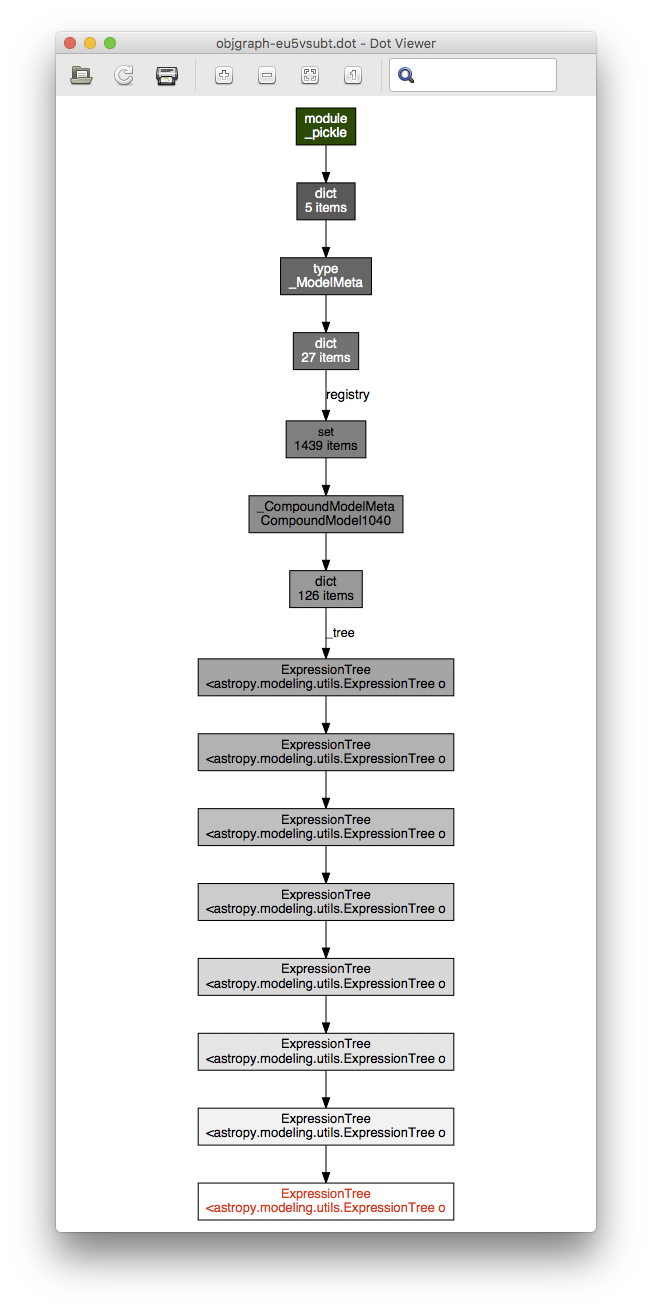

### objgraph: accomplices
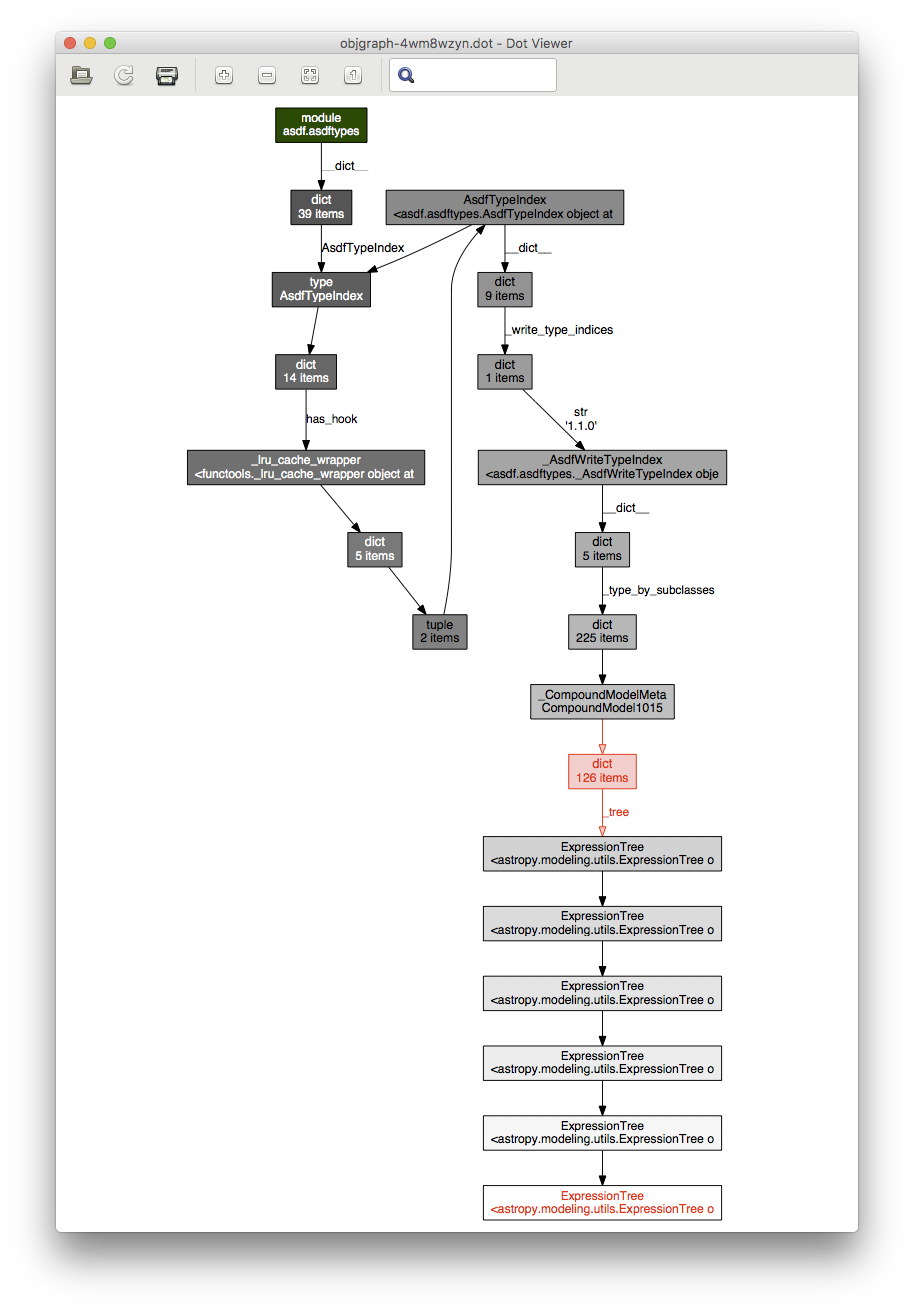

### and...
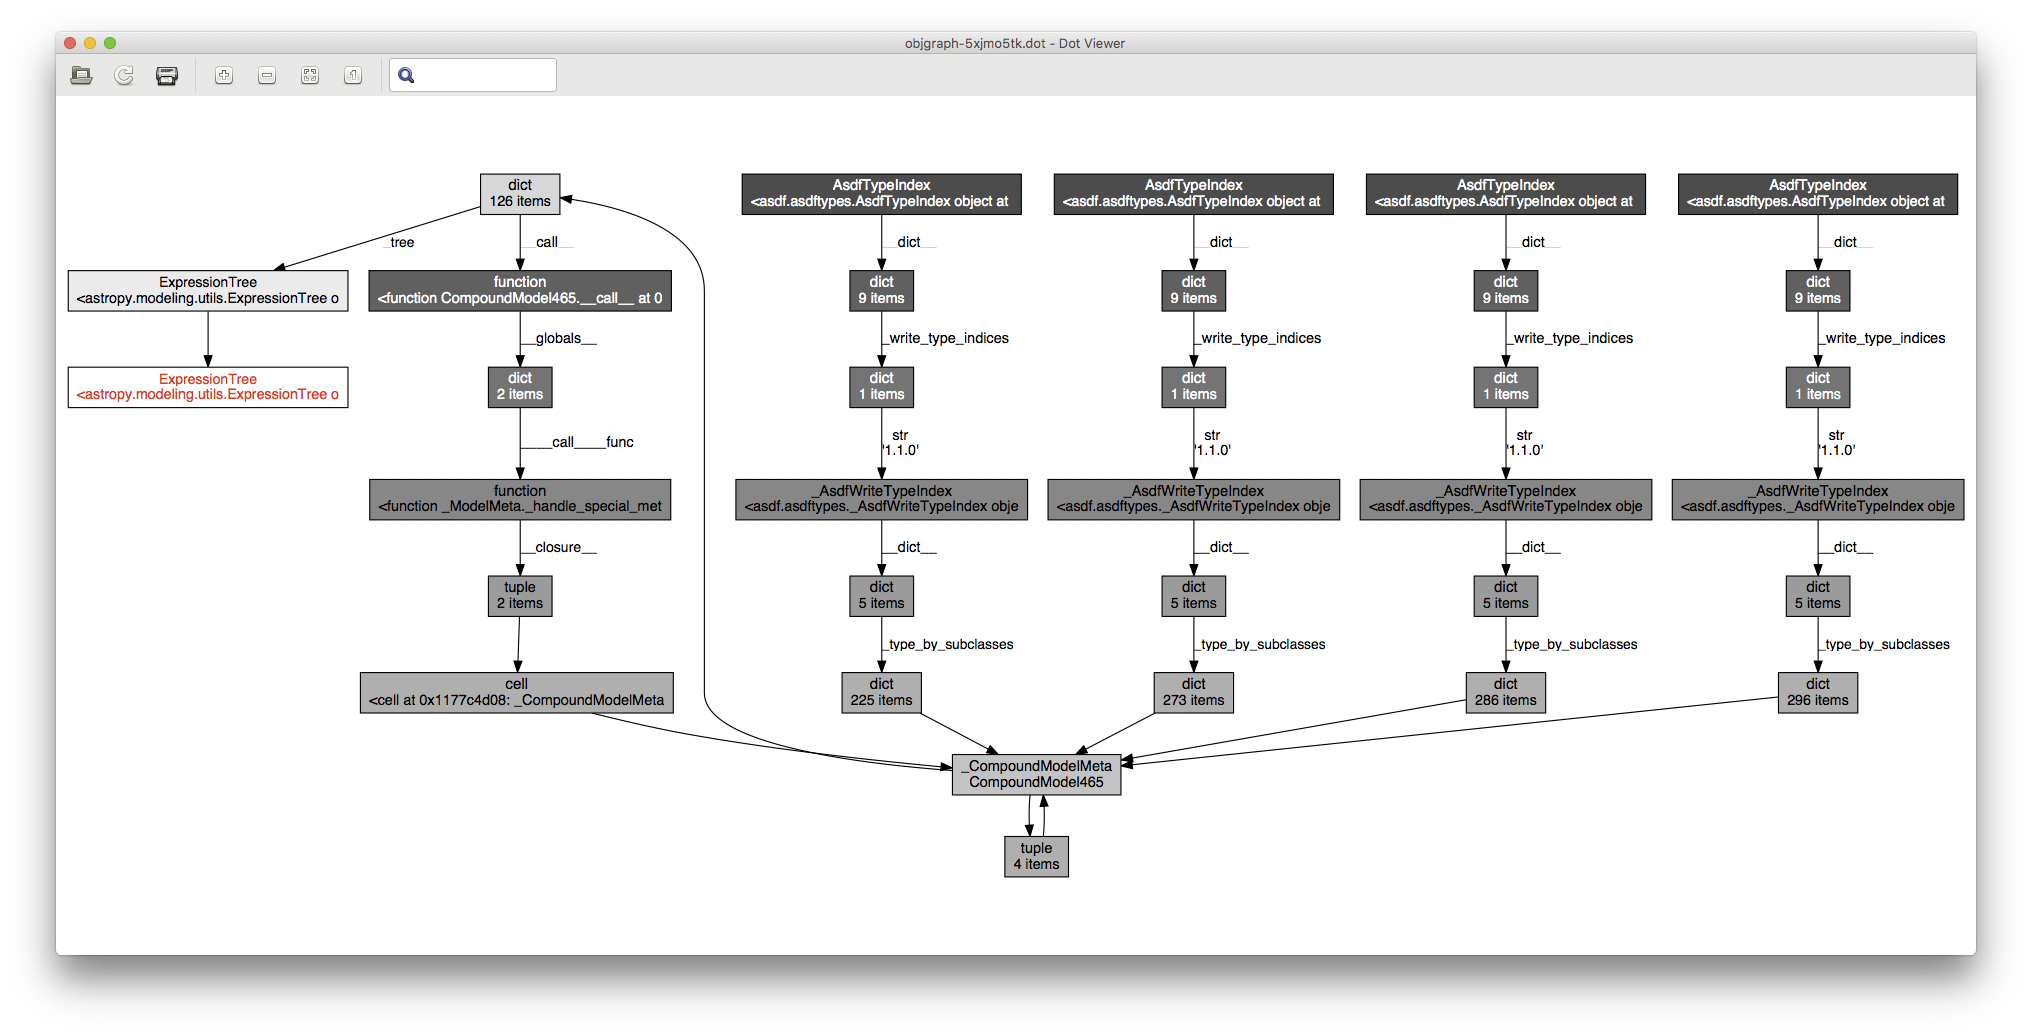

# Resolution

```
Filename: ./calibrate_noloop.py

Line #    Mem usage    Increment   Line Contents
================================================
    24    111.0 MiB      0.0 MiB   @profile
    25                             def main_loop():
    26                                 # Get association and update path to exposures
    27    111.0 MiB      0.0 MiB       with open('member_3_spec2_asn.json') as fp:
    28    111.2 MiB      0.2 MiB           lvl2_asn = load_asn(fp)
    29    111.2 MiB      0.0 MiB       update_path(lvl2_asn, 'level2a_preheaderfix')
    30                             
    31                                 # Process
    32    111.2 MiB      0.0 MiB       to_process = []
    33    111.3 MiB      0.1 MiB       for product in lvl2_asn['products']:
    34    111.3 MiB      0.0 MiB           for member in product['members']:
    35    111.3 MiB      0.0 MiB               if member['exptype'].lower() == 'science':
    36    111.3 MiB      0.0 MiB                   to_process.append(member['expname'])
    37                             
    38    455.1 MiB    343.8 MiB       spec2run(to_process.pop())
    39    455.1 MiB      0.0 MiB       gc.collect()
    40    569.4 MiB    114.2 MiB       spec2run(to_process.pop())
    41    535.6 MiB    -33.8 MiB       gc.collect()
    42    722.9 MiB    187.3 MiB       spec2run(to_process.pop())
    43    722.6 MiB     -0.2 MiB       gc.collect()

```

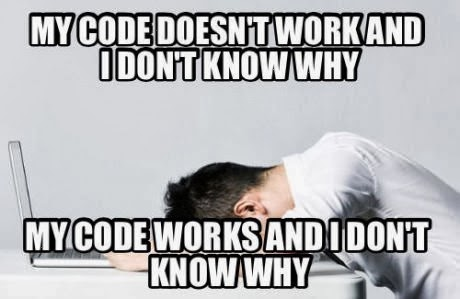

# What now
In principle, it is known why the model registry would hold full DataModels; there is at least one circular reference between the models, DataModels, and the registry.

There does appear to be other Python-level leaks, but these are almost 2 orders of magnitude less than what was experienced. Hence, left as an exercise to the user.

# For your entertainment
The following graph was centered on one of the `objgraph` methods, basically looking for all references.
